In [42]:
from keras import optimizers
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras import backend as K
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from glob import glob
from PIL import Image
from keras.utils.np_utils import to_categorical
from seaborn import set_context
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
RANDOM_STATE = 2401
np.random.seed(RANDOM_STATE)

%matplotlib inline

In [2]:
base_skin_dir = os.path.join('..', 'input')

# Merge images from both folders into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.png'))}

# This dictionary is useful for displaying more human-friendly labels later on

type_dict = {
    0 : 'Grade 1',
    1 : 'Grade 2',
    2 : 'Grade 3'
}

In [3]:
images = []
ids = []
folders = ["../input/tests"]
for folder in folders:
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.resize(img,(256,256))
        if img is not None:
            images.append(img)
            ids.append(filename)

In [4]:
x_test = np.asarray(images)
x_test = x_test/255.0

In [5]:
df = pd.read_csv('../input/embryogrades.csv')

In [6]:
df['path'] = df['id'].map(imageid_path_dict.get)
df['grade'] = df['kelas'].map(type_dict.get)

In [7]:
df.sample(10)

,id,kelas,path,grade
373,kelas2 (232),1,../input/trains/kelas2 (232).png,Grade 2
423,kelas3 (28),2,../input/trains/kelas3 (28).png,Grade 3
258,kelas2 (119),1,../input/trains/kelas2 (119).png,Grade 2
178,kelas2 (73),1,../input/trains/kelas2 (73).png,Grade 2
433,kelas3 (17),2,../input/trains/kelas3 (17).png,Grade 3
382,kelas2 (203),1,../input/trains/kelas2 (203).png,Grade 2
326,kelas2 (128),1,../input/trains/kelas2 (128).png,Grade 2
380,kelas2 (189),1,../input/trains/kelas2 (189).png,Grade 2
426,kelas3 (20),2,../input/trains/kelas3 (20).png,Grade 3
51,kelas1 (117),0,../input/trains/kelas1 (117).png,Grade 1


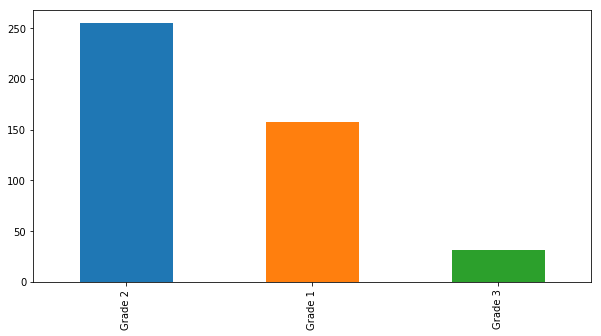

In [8]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df['grade'].value_counts().plot(kind='bar', ax=ax1)

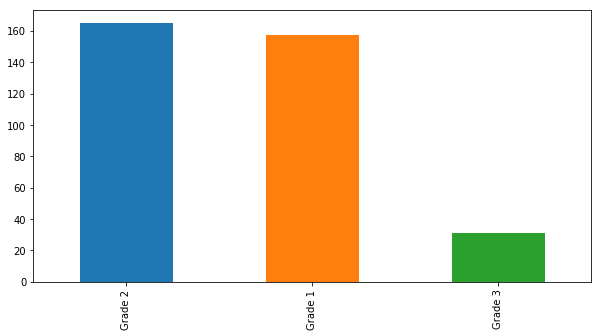

In [9]:
df = df.drop(df[df.kelas == 1].iloc[:90].index)

fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df['grade'].value_counts().plot(kind='bar', ax=ax1)

In [10]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((256,256),1)))

In [11]:
y = df.kelas

**Start Model**

In [12]:
from sklearn.model_selection import train_test_split
x_train_o, x_val_o, y_train_o, y_val_o = train_test_split(df, y, test_size=0.3)
print(x_train_o.shape)

x_train = np.asarray(x_train_o['image'].tolist())
x_val = np.asarray(x_val_o['image'].tolist())
print(x_train.shape)

# x_train_mean = np.mean(x_train)
# x_train_std = np.std(x_train)

# x_val_mean = np.mean(x_val)
# x_val_std = np.std(x_val)
# print(x_val_mean)
# print(x_val_std)

# X_train = (x_train - x_train_mean)/x_train_std
# X_val = (x_val - x_val_mean)/x_val_std
# print(x_train.shape)



(247, 5)
(247, 256, 256, 4)


In [13]:
y_train_o = np.flip(y_train_o)
y_val_o = np.flip(y_val_o)

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 3)
y_val = to_categorical(y_val_o, num_classes = 3)

In [14]:
x_train = np.delete(x_train, 3,3)
x_val = np.delete(x_val, 3,3)

In [15]:
x_train = np.flip(x_train)
x_val = np.flip(x_val)

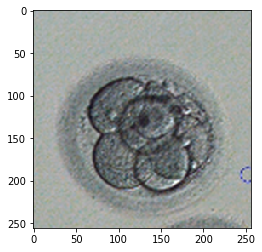

In [16]:
plt.imshow(x_train[246])

In [17]:
x_train = x_train/255.0
x_val = x_val/255.0

In [18]:
from keras.applications.xception import Xception
application = Xception(include_top=False, weights='imagenet',input_shape=(256, 256, 3))

83689472/83683744 [==============================] - 1s 0us/step


In [19]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(application)
 
# Add new layers
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 8, 8, 2048)        20861480  
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 6, 64)          1179712   
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
__________

In [20]:
batch_size = 16
num_classes = 3
epochs = 500

In [21]:
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.00001),metrics=['acc'])
early_stopping = EarlyStopping(monitor='val_acc', min_delta=0,patience=300, verbose=1, mode='max',
                               baseline=None, restore_best_weights=True)
# Train the model
hist = model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_val, y_val),
                 validation_split=0.8,callbacks=[early_stopping])


Train on 247 samples, validate on 106 samples
Epoch 1/500
247/247 [==============================] - 20s 81ms/step - loss: 1.0546 - acc: 0.4251 - val_loss: 0.9433 - val_acc: 0.4528
Epoch 2/500
247/247 [==============================] - 5s 21ms/step - loss: 0.8957 - acc: 0.5142 - val_loss: 0.9121 - val_acc: 0.4717
Epoch 3/500
247/247 [==============================] - 5s 21ms/step - loss: 0.8000 - acc: 0.6316 - val_loss: 0.9041 - val_acc: 0.5000
Epoch 4/500
247/247 [==============================] - 5s 21ms/step - loss: 0.7302 - acc: 0.6518 - val_loss: 0.9003 - val_acc: 0.4717
Epoch 5/500
247/247 [==============================] - 5s 21ms/step - loss: 0.6741 - acc: 0.6964 - val_loss: 0.8838 - val_acc: 0.5472
Epoch 6/500
247/247 [==============================] - 5s 21ms/step - loss: 0.5920 - acc: 0.7976 - val_loss: 0.8756 - val_acc: 0.5566
Epoch 7/500
247/247 [==============================] - 5s 21ms/step - loss: 0.5311 - acc: 0.8178 - val_loss: 0.8756 - val_acc: 0.5755
Epoch 8/500
247

247/247 [==============================] - 5s 21ms/step - loss: 0.0106 - acc: 0.9960 - val_loss: 1.8825 - val_acc: 0.5472
Epoch 122/500
247/247 [==============================] - 5s 21ms/step - loss: 0.0109 - acc: 0.9960 - val_loss: 2.1184 - val_acc: 0.5660
Epoch 123/500
247/247 [==============================] - 5s 21ms/step - loss: 0.0176 - acc: 0.9879 - val_loss: 1.9853 - val_acc: 0.5377
Epoch 124/500
247/247 [==============================] - 5s 21ms/step - loss: 0.0151 - acc: 0.9919 - val_loss: 1.8325 - val_acc: 0.5755
Epoch 125/500
247/247 [==============================] - 5s 21ms/step - loss: 0.0076 - acc: 0.9960 - val_loss: 2.1403 - val_acc: 0.5472
Epoch 126/500
247/247 [==============================] - 5s 21ms/step - loss: 0.0151 - acc: 0.9919 - val_loss: 1.9048 - val_acc: 0.5566
Epoch 127/500
247/247 [==============================] - 5s 21ms/step - loss: 0.0102 - acc: 0.9960 - val_loss: 1.9005 - val_acc: 0.5660
Epoch 128/500
247/247 [==============================] - 5s 21

247/247 [==============================] - 5s 21ms/step - loss: 0.0042 - acc: 1.0000 - val_loss: 2.1422 - val_acc: 0.5849
Epoch 242/500
247/247 [==============================] - 5s 21ms/step - loss: 0.0085 - acc: 0.9919 - val_loss: 2.1494 - val_acc: 0.5943
Epoch 243/500
247/247 [==============================] - 5s 21ms/step - loss: 0.0066 - acc: 0.9960 - val_loss: 2.1491 - val_acc: 0.5849
Epoch 244/500
247/247 [==============================] - 5s 21ms/step - loss: 0.0065 - acc: 0.9960 - val_loss: 2.1595 - val_acc: 0.5849
Epoch 245/500
247/247 [==============================] - 5s 21ms/step - loss: 0.0075 - acc: 0.9960 - val_loss: 2.1676 - val_acc: 0.5849
Epoch 246/500
247/247 [==============================] - 5s 21ms/step - loss: 0.0078 - acc: 0.9919 - val_loss: 2.1588 - val_acc: 0.5943
Epoch 247/500
247/247 [==============================] - 5s 21ms/step - loss: 0.0052 - acc: 1.0000 - val_loss: 2.1489 - val_acc: 0.5849
Epoch 248/500
247/247 [==============================] - 5s 21

247/247 [==============================] - 5s 21ms/step - loss: 0.0055 - acc: 1.0000 - val_loss: 2.1527 - val_acc: 0.6038
Epoch 362/500
247/247 [==============================] - 5s 21ms/step - loss: 0.0067 - acc: 0.9960 - val_loss: 2.1521 - val_acc: 0.6038
Epoch 363/500
247/247 [==============================] - 5s 21ms/step - loss: 0.0062 - acc: 0.9960 - val_loss: 2.1690 - val_acc: 0.6038
Epoch 364/500
247/247 [==============================] - 5s 21ms/step - loss: 0.0053 - acc: 1.0000 - val_loss: 2.1904 - val_acc: 0.6038
Epoch 365/500
247/247 [==============================] - 5s 21ms/step - loss: 0.0066 - acc: 0.9919 - val_loss: 2.2012 - val_acc: 0.6038
Epoch 366/500
247/247 [==============================] - 5s 21ms/step - loss: 0.0062 - acc: 0.9960 - val_loss: 2.2048 - val_acc: 0.6038
Epoch 367/500
247/247 [==============================] - 5s 21ms/step - loss: 0.0058 - acc: 0.9960 - val_loss: 2.2069 - val_acc: 0.6038
Epoch 368/500
247/247 [==============================] - 5s 21

247/247 [==============================] - 5s 21ms/step - loss: 0.0071 - acc: 1.0000 - val_loss: 1.8646 - val_acc: 0.6132
Epoch 482/500
247/247 [==============================] - 5s 21ms/step - loss: 0.0040 - acc: 1.0000 - val_loss: 1.8916 - val_acc: 0.6226
Epoch 483/500
247/247 [==============================] - 5s 21ms/step - loss: 0.0240 - acc: 0.9879 - val_loss: 1.8143 - val_acc: 0.6321
Epoch 484/500
247/247 [==============================] - 5s 21ms/step - loss: 0.0074 - acc: 0.9960 - val_loss: 1.9472 - val_acc: 0.6038
Epoch 485/500
247/247 [==============================] - 5s 21ms/step - loss: 0.0144 - acc: 0.9879 - val_loss: 1.7219 - val_acc: 0.6226
Epoch 486/500
247/247 [==============================] - 5s 21ms/step - loss: 0.0064 - acc: 1.0000 - val_loss: 1.7069 - val_acc: 0.6509
Epoch 487/500
247/247 [==============================] - 5s 21ms/step - loss: 0.0077 - acc: 0.9960 - val_loss: 1.7349 - val_acc: 0.6415
Epoch 488/500
247/247 [==============================] - 5s 21

In [22]:
from keras.applications.resnet50 import ResNet50
application = ResNet50(include_top=False, weights='imagenet',input_shape=(256, 256, 3))

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


In [23]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model2 = models.Sequential()
 
# Add the vgg convolutional base model
model2.add(application)
 
# Add new layers
model2.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(3, 3)))
model2.add(Flatten())
model2.add(Dropout(0.25))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(3, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 64)          1179712   
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
__________

In [24]:
batch_size = 16
num_classes = 3
epochs = 500

In [25]:
model2.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.00001),metrics=['acc'])
early_stopping = EarlyStopping(monitor='val_acc', min_delta=0,patience=300, verbose=1, mode='max',
                               baseline=None, restore_best_weights=True)
# Train the model
hist2 = model2.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_val, y_val),
                 validation_split=0.8,callbacks=[early_stopping])


Train on 247 samples, validate on 106 samples
Epoch 1/500
247/247 [==============================] - 19s 76ms/step - loss: 3.7027 - acc: 0.0972 - val_loss: 1.9246 - val_acc: 0.1038
Epoch 2/500
247/247 [==============================] - 3s 13ms/step - loss: 1.5125 - acc: 0.2672 - val_loss: 1.1558 - val_acc: 0.3491
Epoch 3/500
247/247 [==============================] - 3s 13ms/step - loss: 0.9382 - acc: 0.5304 - val_loss: 1.0329 - val_acc: 0.4906
Epoch 4/500
247/247 [==============================] - 3s 13ms/step - loss: 0.8179 - acc: 0.6194 - val_loss: 1.0010 - val_acc: 0.5189
Epoch 5/500
247/247 [==============================] - 3s 13ms/step - loss: 0.6479 - acc: 0.7045 - val_loss: 0.9646 - val_acc: 0.5566
Epoch 6/500
247/247 [==============================] - 3s 12ms/step - loss: 0.5566 - acc: 0.7733 - val_loss: 0.9515 - val_acc: 0.5283
Epoch 7/500
247/247 [==============================] - 3s 12ms/step - loss: 0.5532 - acc: 0.7773 - val_loss: 0.9630 - val_acc: 0.5377
Epoch 8/500
247

247/247 [==============================] - 3s 13ms/step - loss: 0.0128 - acc: 0.9919 - val_loss: 1.4809 - val_acc: 0.5943
Epoch 122/500
247/247 [==============================] - 3s 13ms/step - loss: 0.0115 - acc: 0.9919 - val_loss: 1.4612 - val_acc: 0.6038
Epoch 123/500
247/247 [==============================] - 3s 13ms/step - loss: 0.0114 - acc: 0.9919 - val_loss: 1.4748 - val_acc: 0.6038
Epoch 124/500
247/247 [==============================] - 3s 13ms/step - loss: 0.0183 - acc: 0.9919 - val_loss: 1.4733 - val_acc: 0.6038
Epoch 125/500
247/247 [==============================] - 3s 13ms/step - loss: 0.0152 - acc: 0.9919 - val_loss: 1.4844 - val_acc: 0.6038
Epoch 126/500
247/247 [==============================] - 3s 13ms/step - loss: 0.0096 - acc: 0.9960 - val_loss: 1.4501 - val_acc: 0.6226
Epoch 127/500
247/247 [==============================] - 3s 13ms/step - loss: 0.0048 - acc: 1.0000 - val_loss: 1.4269 - val_acc: 0.6226
Epoch 128/500
247/247 [==============================] - 3s 13

247/247 [==============================] - 3s 13ms/step - loss: 0.0074 - acc: 0.9960 - val_loss: 1.5481 - val_acc: 0.6321
Epoch 242/500
247/247 [==============================] - 3s 13ms/step - loss: 0.0096 - acc: 0.9919 - val_loss: 1.5542 - val_acc: 0.6321
Epoch 243/500
247/247 [==============================] - 3s 13ms/step - loss: 0.0064 - acc: 0.9960 - val_loss: 1.5683 - val_acc: 0.6226
Epoch 244/500
247/247 [==============================] - 3s 13ms/step - loss: 0.0087 - acc: 0.9919 - val_loss: 1.5954 - val_acc: 0.6226
Epoch 245/500
247/247 [==============================] - 3s 13ms/step - loss: 0.0053 - acc: 0.9960 - val_loss: 1.5803 - val_acc: 0.6321
Epoch 246/500
247/247 [==============================] - 3s 13ms/step - loss: 0.0045 - acc: 0.9960 - val_loss: 1.5748 - val_acc: 0.6321
Epoch 247/500
247/247 [==============================] - 3s 13ms/step - loss: 0.0067 - acc: 0.9960 - val_loss: 1.5939 - val_acc: 0.6321
Epoch 248/500
247/247 [==============================] - 3s 13

247/247 [==============================] - 3s 13ms/step - loss: 0.0093 - acc: 0.9919 - val_loss: 1.8545 - val_acc: 0.5943
Epoch 362/500
247/247 [==============================] - 3s 13ms/step - loss: 0.0115 - acc: 0.9919 - val_loss: 1.9048 - val_acc: 0.5943
Epoch 363/500
247/247 [==============================] - 3s 13ms/step - loss: 0.0096 - acc: 0.9919 - val_loss: 1.9121 - val_acc: 0.5943
Epoch 364/500
247/247 [==============================] - 3s 13ms/step - loss: 0.0082 - acc: 0.9919 - val_loss: 1.8996 - val_acc: 0.5943
Epoch 365/500
247/247 [==============================] - 3s 12ms/step - loss: 0.0061 - acc: 0.9960 - val_loss: 1.9433 - val_acc: 0.6038
Epoch 366/500
247/247 [==============================] - 3s 13ms/step - loss: 0.0049 - acc: 1.0000 - val_loss: 1.9650 - val_acc: 0.6038
Epoch 367/500
247/247 [==============================] - 3s 13ms/step - loss: 0.0070 - acc: 0.9960 - val_loss: 1.9641 - val_acc: 0.6038
Epoch 368/500
247/247 [==============================] - 3s 13

247/247 [==============================] - 3s 13ms/step - loss: 0.0065 - acc: 1.0000 - val_loss: 1.5024 - val_acc: 0.5943
Epoch 482/500
247/247 [==============================] - 3s 13ms/step - loss: 0.0097 - acc: 0.9919 - val_loss: 1.4975 - val_acc: 0.5849
Epoch 483/500
247/247 [==============================] - 3s 13ms/step - loss: 0.0103 - acc: 0.9919 - val_loss: 1.5281 - val_acc: 0.5943
Epoch 484/500
247/247 [==============================] - 3s 13ms/step - loss: 0.0101 - acc: 0.9919 - val_loss: 1.5604 - val_acc: 0.5849
Epoch 485/500
247/247 [==============================] - 3s 13ms/step - loss: 0.0038 - acc: 1.0000 - val_loss: 1.5520 - val_acc: 0.6226
Epoch 486/500
247/247 [==============================] - 3s 13ms/step - loss: 0.0085 - acc: 0.9960 - val_loss: 1.5575 - val_acc: 0.6226
Epoch 487/500
247/247 [==============================] - 3s 13ms/step - loss: 0.0051 - acc: 1.0000 - val_loss: 1.7363 - val_acc: 0.5943
Epoch 488/500
247/247 [==============================] - 3s 13

In [26]:
from keras.applications.mobilenet import MobileNet
application = MobileNet(include_top=False, weights='imagenet',input_shape=(256, 256, 3))

/opt/conda/lib/python3.6/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 0s 0us/step


In [27]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model3 = models.Sequential()
 
# Add the vgg convolutional base model
model3.add(application)
 
# Add new layers
model3.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(3, 3)))
model3.add(Flatten())
model3.add(Dropout(0.25))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(3, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 8, 8, 1024)        3228864   
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 6, 6, 64)          589888    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
__________

In [28]:
batch_size = 16
num_classes = 3
epochs = 500

In [29]:
model3.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.00001),metrics=['acc'])
early_stopping = EarlyStopping(monitor='val_acc', min_delta=0,patience=300, verbose=1, mode='max',
                               baseline=None, restore_best_weights=True)
# Train the model
hist3 = model3.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_val, y_val),
                 validation_split=0.8,callbacks=[early_stopping])


Train on 247 samples, validate on 106 samples
Epoch 1/500
247/247 [==============================] - 13s 53ms/step - loss: 1.6662 - acc: 0.3522 - val_loss: 1.0944 - val_acc: 0.4245
Epoch 2/500
247/247 [==============================] - 2s 9ms/step - loss: 1.1569 - acc: 0.4737 - val_loss: 1.0490 - val_acc: 0.4906
Epoch 3/500
247/247 [==============================] - 2s 9ms/step - loss: 0.8781 - acc: 0.5870 - val_loss: 1.0180 - val_acc: 0.4906
Epoch 4/500
247/247 [==============================] - 2s 9ms/step - loss: 0.9411 - acc: 0.5547 - val_loss: 0.9991 - val_acc: 0.4811
Epoch 5/500
247/247 [==============================] - 2s 9ms/step - loss: 0.7997 - acc: 0.6275 - val_loss: 0.9899 - val_acc: 0.5094
Epoch 6/500
247/247 [==============================] - 2s 9ms/step - loss: 0.7580 - acc: 0.6316 - val_loss: 0.9838 - val_acc: 0.5000
Epoch 7/500
247/247 [==============================] - 2s 9ms/step - loss: 0.6933 - acc: 0.7126 - val_loss: 0.9754 - val_acc: 0.4811
Epoch 8/500
247/247 [

Epoch 62/500
247/247 [==============================] - 2s 9ms/step - loss: 0.0283 - acc: 0.9919 - val_loss: 1.0798 - val_acc: 0.5660
Epoch 63/500
247/247 [==============================] - 2s 9ms/step - loss: 0.0442 - acc: 0.9838 - val_loss: 1.0821 - val_acc: 0.5943
Epoch 64/500
247/247 [==============================] - 2s 9ms/step - loss: 0.0202 - acc: 1.0000 - val_loss: 1.0739 - val_acc: 0.6038
Epoch 65/500
247/247 [==============================] - 2s 9ms/step - loss: 0.0311 - acc: 0.9960 - val_loss: 1.0784 - val_acc: 0.6038
Epoch 66/500
247/247 [==============================] - 2s 9ms/step - loss: 0.0385 - acc: 0.9919 - val_loss: 1.0884 - val_acc: 0.6038
Epoch 67/500
247/247 [==============================] - 2s 9ms/step - loss: 0.0222 - acc: 0.9960 - val_loss: 1.0868 - val_acc: 0.5755
Epoch 68/500
247/247 [==============================] - 2s 9ms/step - loss: 0.0307 - acc: 0.9960 - val_loss: 1.0913 - val_acc: 0.5755
Epoch 69/500
247/247 [==============================] - 2s 9ms

Epoch 123/500
247/247 [==============================] - 2s 9ms/step - loss: 0.0102 - acc: 1.0000 - val_loss: 1.2090 - val_acc: 0.5566
Epoch 124/500
247/247 [==============================] - 2s 9ms/step - loss: 0.0107 - acc: 0.9960 - val_loss: 1.2139 - val_acc: 0.5660
Epoch 125/500
247/247 [==============================] - 2s 9ms/step - loss: 0.0134 - acc: 0.9960 - val_loss: 1.2076 - val_acc: 0.5660
Epoch 126/500
247/247 [==============================] - 2s 9ms/step - loss: 0.0236 - acc: 0.9919 - val_loss: 1.1933 - val_acc: 0.5566
Epoch 127/500
247/247 [==============================] - 2s 9ms/step - loss: 0.0213 - acc: 0.9960 - val_loss: 1.2029 - val_acc: 0.5566
Epoch 128/500
247/247 [==============================] - 2s 9ms/step - loss: 0.0089 - acc: 1.0000 - val_loss: 1.2312 - val_acc: 0.5849
Epoch 129/500
247/247 [==============================] - 2s 9ms/step - loss: 0.0222 - acc: 0.9919 - val_loss: 1.2344 - val_acc: 0.5755
Epoch 130/500
247/247 [==============================] 

Epoch 244/500
247/247 [==============================] - 2s 9ms/step - loss: 0.0038 - acc: 1.0000 - val_loss: 1.3115 - val_acc: 0.5755
Epoch 245/500
247/247 [==============================] - 2s 9ms/step - loss: 0.0095 - acc: 0.9960 - val_loss: 1.3116 - val_acc: 0.5755
Epoch 246/500
247/247 [==============================] - 2s 9ms/step - loss: 0.0066 - acc: 0.9960 - val_loss: 1.3176 - val_acc: 0.5849
Epoch 247/500
247/247 [==============================] - 2s 9ms/step - loss: 0.0203 - acc: 0.9919 - val_loss: 1.3246 - val_acc: 0.5849
Epoch 248/500
247/247 [==============================] - 2s 9ms/step - loss: 0.0067 - acc: 0.9960 - val_loss: 1.3302 - val_acc: 0.5755
Epoch 249/500
247/247 [==============================] - 2s 9ms/step - loss: 0.0063 - acc: 0.9960 - val_loss: 1.3349 - val_acc: 0.5755
Epoch 250/500
247/247 [==============================] - 2s 9ms/step - loss: 0.0090 - acc: 0.9960 - val_loss: 1.3465 - val_acc: 0.5660
Epoch 251/500
247/247 [==============================] 

In [30]:
# Save the model
model.save('best.h5')

In [43]:
set_context("talk")

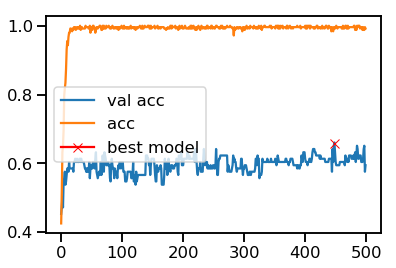

In [44]:
plt.plot(hist.history['val_acc'], label="val acc")
plt.plot(hist.history['acc'], label="acc")
plt.plot( np.argmax(hist.history["val_acc"]), np.max(hist.history["val_acc"]), 
         marker="x", color="r", label="best model")
plt.legend()
plt.show()

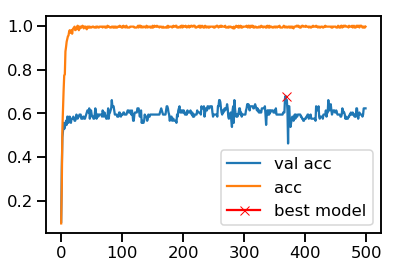

In [45]:
plt.plot(hist2.history['val_acc'], label="val acc")
plt.plot(hist2.history['acc'], label="acc")
plt.plot( np.argmax(hist2.history["val_acc"]), np.max(hist2.history["val_acc"]), 
         marker="x", color="r", label="best model")
plt.legend()
plt.show()

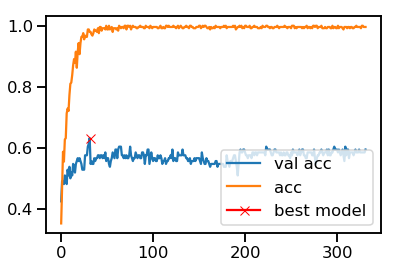

In [46]:
plt.plot(hist3.history['val_acc'], label="val acc")
plt.plot(hist3.history['acc'], label="acc")
plt.plot( np.argmax(hist3.history["val_acc"]), np.max(hist3.history["val_acc"]), 
         marker="x", color="r", label="best model")
plt.legend()
plt.show()

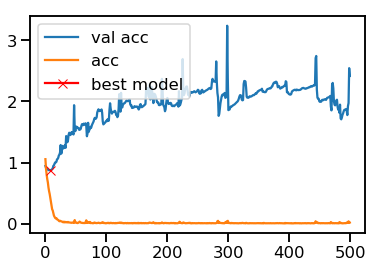

In [47]:
plt.plot(hist.history['val_loss'], label="val acc")
plt.plot(hist.history['loss'], label="acc")
plt.plot( np.argmin(hist.history["val_loss"]), np.min(hist.history["val_loss"]), 
         marker="x", color="r", label="best model")
plt.legend()
plt.show()

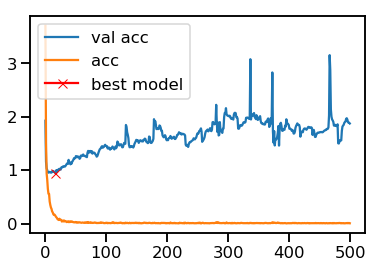

In [48]:
plt.plot(hist2.history['val_loss'], label="val acc")
plt.plot(hist2.history['loss'], label="acc")
plt.plot( np.argmin(hist2.history["val_loss"]), np.min(hist2.history["val_loss"]), 
         marker="x", color="r", label="best model")
plt.legend()
plt.show()

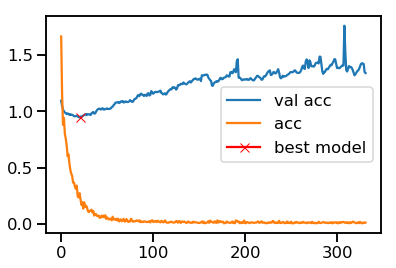

In [49]:
plt.plot(hist3.history['val_loss'], label="val acc")
plt.plot(hist3.history['loss'], label="acc")
plt.plot( np.argmin(hist3.history["val_loss"]), np.min(hist3.history["val_loss"]), 
         marker="x", color="r", label="best model")
plt.legend()
plt.show()

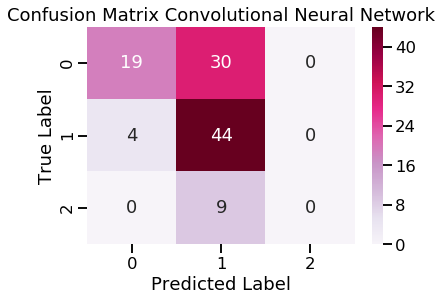

In [50]:
y_pred = model.predict_classes(x_val)
cm = confusion_matrix(np.argmax(y_val,axis=1),y_pred)

ax = plt.axes()
sns.heatmap(cm, annot=True, fmt="d", cmap="PuRd") #-___-
ax.set_title('Confusion Matrix Convolutional Neural Network')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
plt.show()

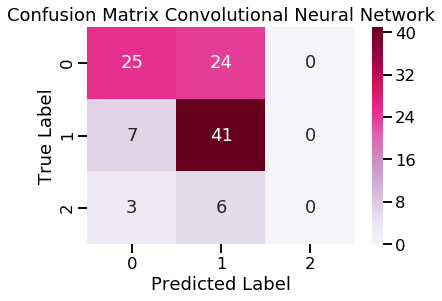

In [51]:
y_pred = model2.predict_classes(x_val)
cm = confusion_matrix(np.argmax(y_val,axis=1),y_pred)

ax = plt.axes()
sns.heatmap(cm, annot=True, fmt="d", cmap="PuRd") #-___-
ax.set_title('Confusion Matrix Convolutional Neural Network')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
plt.show()

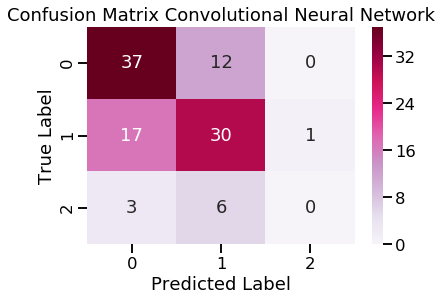

In [52]:
y_pred = model3.predict_classes(x_val)
cm = confusion_matrix(np.argmax(y_val,axis=1),y_pred)

ax = plt.axes()
sns.heatmap(cm, annot=True, fmt="d", cmap="PuRd") #-___-
ax.set_title('Confusion Matrix Convolutional Neural Network')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
plt.show()

In [57]:
y_pred_test = model3.predict_classes(x_test)

rdf = pd.DataFrame(columns=['id','kelas'])
rdf['id'] = ids.copy()
rdf['kelas'] = y_pred_test.copy()
rdf.to_csv("results.csv",index=False)

In [58]:
from IPython.display import HTML
import base64

def create_download_link(rdf, title = "Download CSV file", filename = "results.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe
create_download_link(rdf)